## Stochastic SIR network model on City of London boroughs

Authors:
- Alex Zarebski @aezarebski
- Gerry Tonkin-Hill @gtonkinhill

Date: 2018-10-03

### Summary

In this notebook we demonstrate how to work with spatial data files using R. We use shape files of the burrows of London and then represent this as a network. We then simulate a stochastic network epidemic model on the resulting network and then create an animation of the simulation.

### Model and implementation

Let's simulate an epidemic in the City of London and Camden. We start by getting the shape files for Camden and the City of London from the council website. It is available as a ZIP file here:

https://data.london.gov.uk/dataset/2011-boundary-files

In this notebook we will carry out the following steps.

1. Construct a map of London and Camden;
2. Construct a network of locations in London and Camden; and
3. Simulate an epidemic on this map using a stochastic SIR model.

There is some initial set up of the system to handle shape files. Uncomment the following lines if downloading for the first time.

In [1]:
#data_url <- "https://files.datapress.com/london/dataset/2011-boundary-files/2011_london_boundaries.zip"
#zip_fn <- "london.zip"
#download.file(data_url, zip_fn)
#unzip(zip_fn)

In [2]:
set.seed(33333334) # for reproducibility
library(maptools)
library(rgdal)
library(data.table)
library(ggplot2)
library(plyr)
library(gganimate)

Loading required package: sp
Checking rgeos availability: TRUE
rgdal: version: 1.3-6, (SVN revision 773)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.2.3, released 2017/11/20
 Path to GDAL shared files: /usr/share/gdal/2.2
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
 Path to PROJ.4 shared files: (autodetected)
 Linking to sp version: 1.3-1 


Set up a coordinate reference system.

In [3]:
crswgs84=CRS("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

Read in the data and plot.

Warning message:
“readShapePoly is deprecated; use rgdal::readOGR or sf::st_read”Warning message:
“readShapePoly is deprecated; use rgdal::readOGR or sf::st_read”

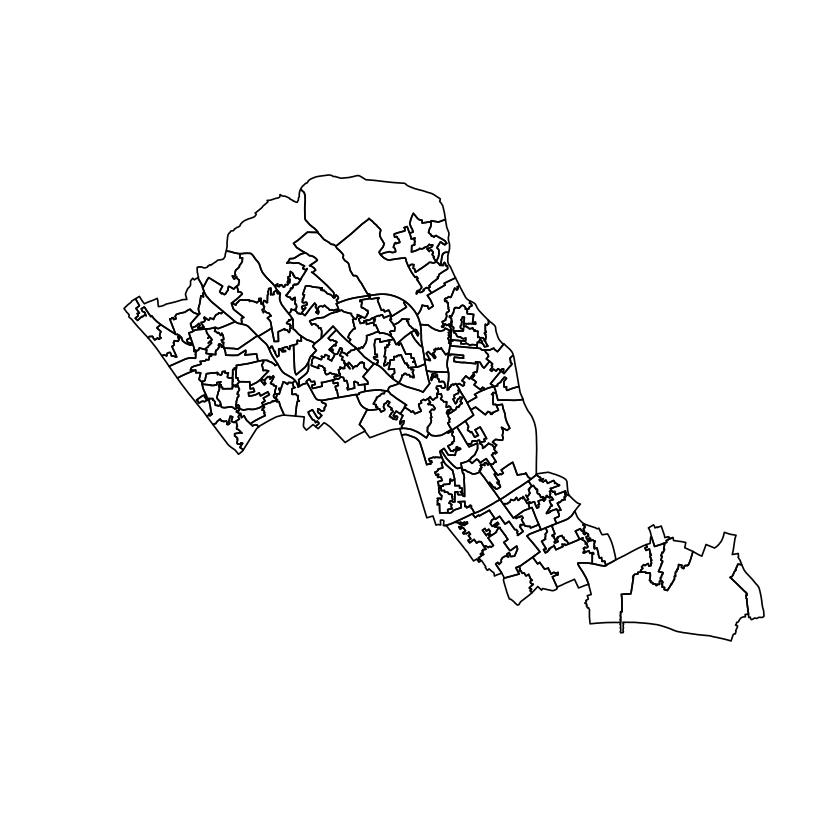

In [4]:
lon <- maptools::readShapePoly("LSOA_2011_BFE_City_of_London.shp")
cam <- readShapePoly("LSOA_2011_BFE_Camden.shp")
lon <- rbind(lon, cam)
plot(lon)

Although we have areas in the City of London, these are not terribly helpful to work with, so let's construct a network from this. We start by computing which polygons share edges.

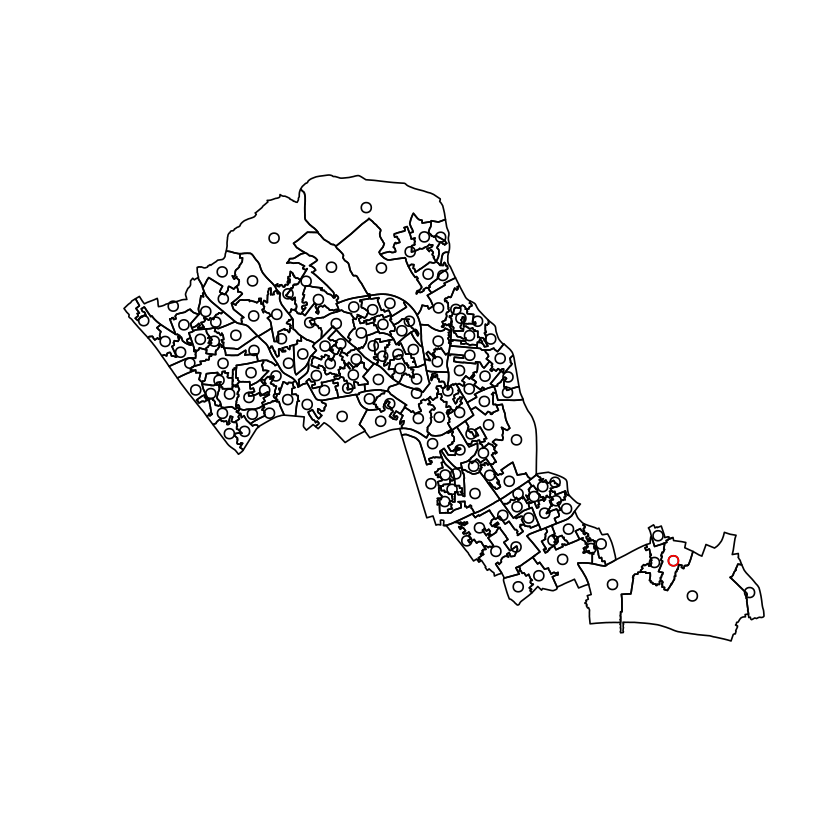

In [5]:
lon_coords <- sp::coordinates(lon)  # Coordinates of polygon centers
lon_nbs <- spdep::poly2nb(lon)  # Neighbour relationships based on a triangulation

rownames(lon_coords) <- lon$LSOA11NM
plot(lon)
points(lon_coords)
points(lon_coords[2,1], lon_coords[2,2], col="red")

But what are the strengths of the connections between these coordinates? For this we need a matrix of weights on the edges of the graph.

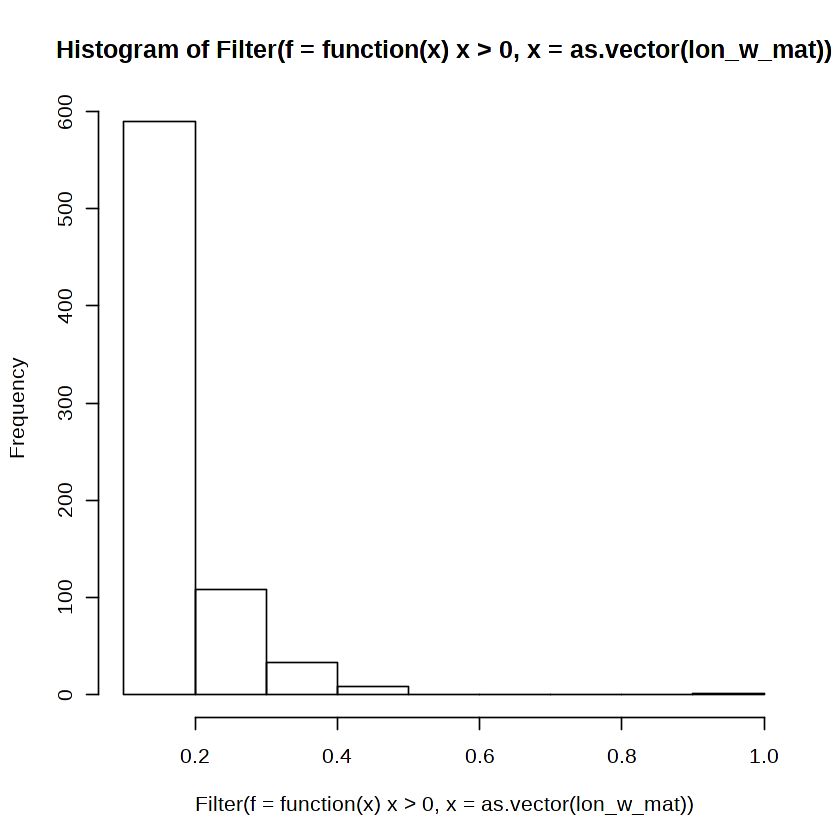

In [6]:
lon_w_mat <- spdep::nb2mat(lon_nbs)  # Weight matrix between the nodes.
colnames(lon_w_mat) <- rownames(lon_w_mat)
hist(Filter(f = function(x) x > 0, x = as.vector(lon_w_mat)))

Then we can draw just the edges that have a connection stronger than a threshold.

NULL

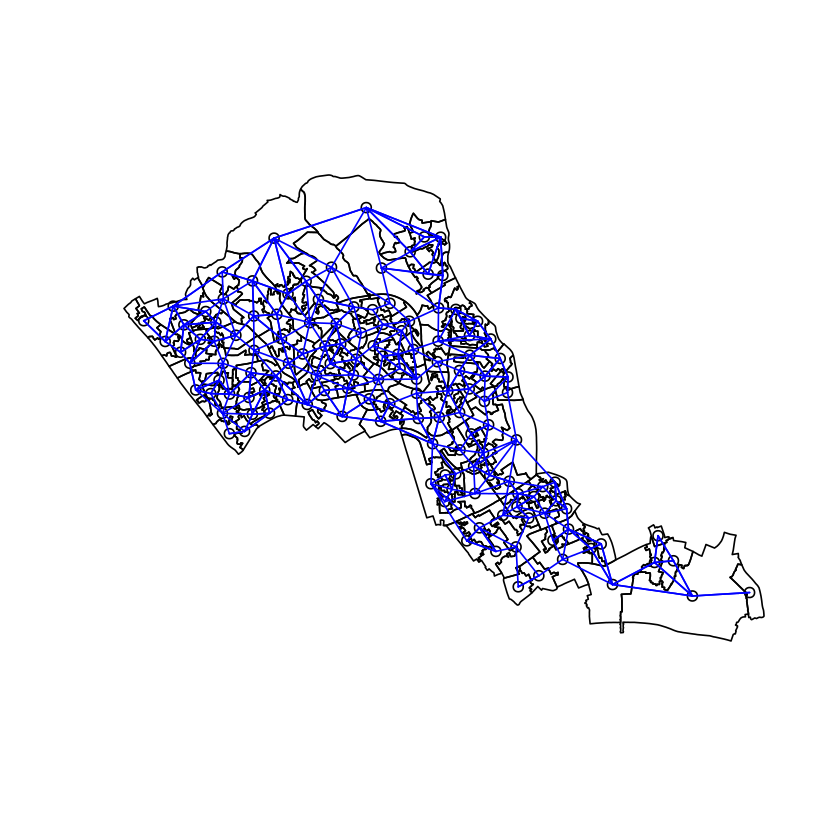

In [7]:
num_nbs <- length(lon_nbs)
threshold <- 0.16
plot(lon)
points(lon_coords)

adj_matrix <- lon_w_mat>threshold
dimnames(adj_matrix) <- NULL

edges <- which(adj_matrix, arr.ind = TRUE)
apply(edges, 1, function(r){
  lines(lon_coords[r,1], lon_coords[r,2], col="blue")
})

Woohoo! We have a network between areas in London and Camden. We can now set some paramters for an SIR model which we would like to simulate.

In [8]:
#transmission rate
beta <- 3

#recovery rate
gamma <- 1

n.nodes <- ncol(adj_matrix)
status.vector <- rep("S", n.nodes)

Randomly initialise an infected person

In [9]:
status.vector[sample(length(status.vector), 1)] <- "I"
names(status.vector) <- 1:n.nodes
colnames(adj_matrix) <- rownames(adj_matrix) <- 1:n.nodes

We now implement the Gillespie algorithm to simulate the SIR model on the network of London. Basically, this involves infection spreading from infected locations to neighbouring uninfected locations. Infected locations recover from the infection at a constant rate. After recovery, locations are essentially irrelevant to the rest of the simulation.

In [10]:
#matrix and vector to store results at each time step
time.steps <- rep(NA, 2*n.nodes)
status.matrix <- matrix(NA, nrow = 2*n.nodes, ncol = n.nodes)

time.steps[[1]] <- 0
status.matrix[1,] <- status.vector

#run until
stopping.time <- 10

#initialise time
current.time <- 0
time.step <- 1

while(current.time < stopping.time){
  # message for debugging
  # message(paste(c("time step:", time.step, "current time:", current.time), collapse = " "))
  
  #calculate vector recovery rates for each infected person
  recovery.rates <- rep(gamma, sum(status.vector=="I"))
  names(recovery.rates) <- c(1:n.nodes)[status.vector=="I"]
  
  #infection rates for each suceptiable person
  infection.rates <- rowSums(adj_matrix[,status.vector=="I",drop=FALSE])[status.vector=="S"]
  infection.rates <- infection.rates*beta
  names(infection.rates) <- c(1:n.nodes)[status.vector=="S"]
  
  #sample event
  event.rate <- sum(recovery.rates, infection.rates)
  if(event.rate<=0){
    #we've reached the end of the simulation
    break
  }
  
  p <- c(recovery.rates, infection.rates)/event.rate
  event.num <- sample(names(p), 1, prob = p)
  
  #update status
  if(status.vector[event.num]=="S"){
    status.vector[event.num] <- "I"
  } else if (status.vector[event.num]=="I") {
    status.vector[event.num] <- "R"
  } else {
    stop("bad index!")
  }
  
  #sample time to event
  current.time <- current.time + rexp(1, rate = event.rate)
  time.step <- time.step + 1
  
  #update results
  time.steps[[time.step]] <- current.time
  status.matrix[time.step, ] <- status.vector
}

time.steps <- time.steps[1:time.step]
status.matrix <- status.matrix[1:time.step,]

We plot the proportions of each state as a function of time to summarise the simulation in a clear way. This is essentially the well known SIR curves.

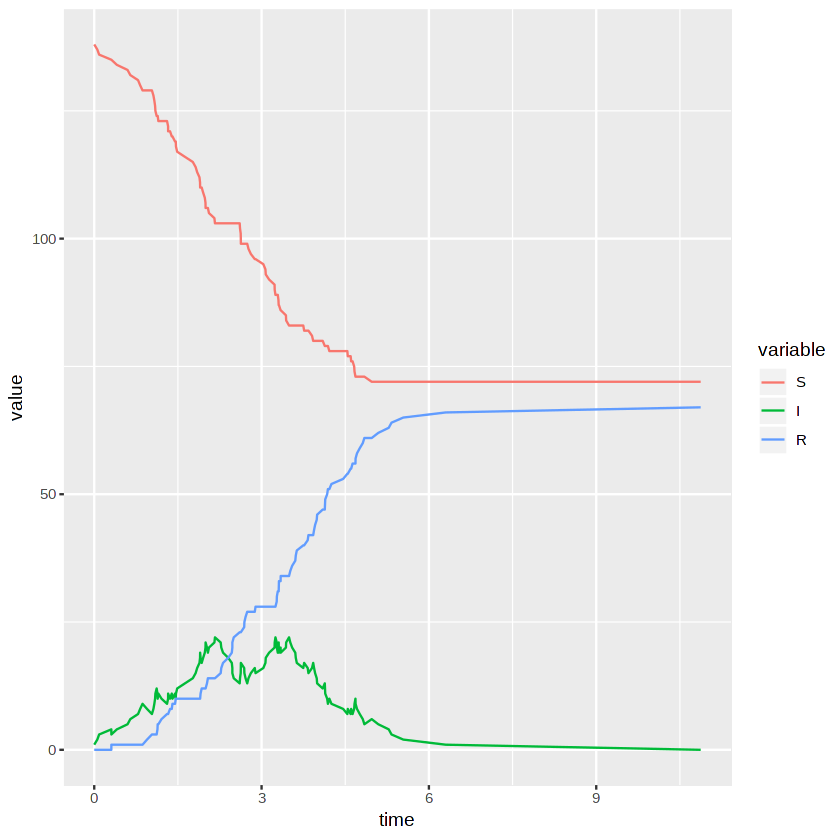

In [11]:
results.df <- data.frame(t(apply(status.matrix, 1, function(r){
  table(factor(r, levels = list("S", "I", "R")))
  })), stringsAsFactors = FALSE)

results.df$time <- time.steps
results.df <- melt(results.df, id.vars="time")

ggplot(results.df, aes(x=time, y=value, col=variable)) + geom_line()

This code sets up the rendering of an animated visualisation of the network.

In [12]:
results.df <- melt(status.matrix)
colnames(results.df) <- c("time step", "node", "status")
results.df <- cbind(results.df, lon_coords[results.df$node,], rownames(lon_coords))
results.df$node <- rownames(lon_coords)[results.df$node]
colnames(results.df) <- c("time step", "node", "status", "lat", "long", "area")

lon@data$id = rownames(lon@data)
london.points = fortify(lon, region="id")
london.df = join(london.points, lon@data, by="id")

plot.df <- do.call(rbind, lapply(unique(results.df$`time step`), function(t){
  temp.df <- results.df[results.df$`time step`==t,]
  london.df$status <- temp.df$status[match(as.character(london.df$LSOA11NM), temp.df$node)]
  london.df$time <- t
  return(london.df)
}))

gg <- ggplot(plot.df) + 
  aes(long,lat, group=group, fill=status) + 
  geom_polygon() +
  geom_path(color="white") +
  coord_equal() + 
  # Here comes the gganimate code
  transition_manual(time)

We render and save the animation as a GIF.

In [13]:
anim_save("london.gif",animate(gg))

Frame 100 (100%)
Finalizing encoding... done!


The following code displays the GIF in the notebook inline.


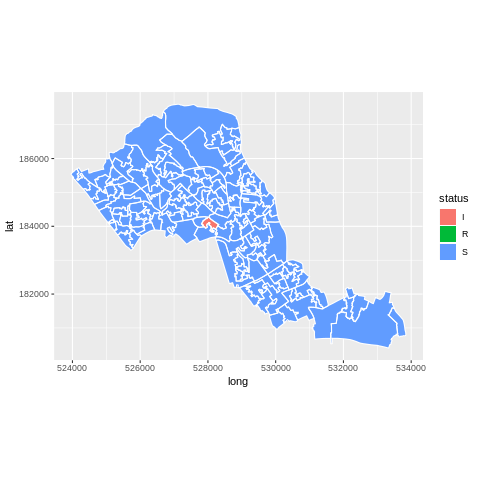

In [14]:
contents <- base64enc::base64encode("london.gif")
tag <- '<img src="data:image/gif;base64,%s">'
IRdisplay::display_html(sprintf(tag, contents))